```{eval-rst}
.. include:: ../sinebow.rst

```
{header-2}`Omnipose in 3D`
==========================

You can use the `dim` (dimension) argument to tell Omnipose to segment your images using a 3D model. This means that an image stack or 3D array is treated as a 3D volume given to a network trained on 3D volumes. This is very different from `do_3D` in Cellpose, which cleverly leveraged 2D predictions on all 2D slices of a 3D volume to construct a 3D flow field for segmentation. It turns out that the pseudo-ND Cellpose flows are an approximation to the true 3D flows of Omnipose, because the flows in each slice point to a local center of the cell, a.k.a. the cell skeleton to which the Omnipose field points. Thus, is not recommended to use Omnipose 2D slice predictions with `do_3D`. Instead, this notebook assumes you have trained a 3D model such as the `plant_omni` model.

In [ ]:
# make local editable packages automatically reload
%load_ext autoreload
%autoreload 2

# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-11 21:22:36,193 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? 1


## Read in data
Here I am chose one of the scaled-down volumes of the plant *Arabidopsis thaliana* dataset we used in the Omnipose paper. 

In [ ]:
from pathlib import Path
import os
from cellpose_omni import io

basedir = os.path.join(Path.cwd().parent,'test_files_3D')
files = io.get_image_files(basedir)
files # this displays the variable if it the last thing in the code block

['/home/kcutler/DataDrive/omnipose/docs/test_files_3D/Movie1_t00004_crop_gt.tif']

In [ ]:
from cellpose_omni import io, transforms
from omnipose.utils import normalize99

imgs = [io.imread(f) for f in files]

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range:', i.min(),i.max())
nimg = len(imgs)
print('number of images:',nimg)

Original image shape: (162, 207, 443)
data type: uint8
data range: 0 247
number of images: 1


## Initialize model
`plant_omni` is the model trained on these plant cell images. (The image we loaded is from the test set, of course.)

In [ ]:
from cellpose_omni import models
model_name = 'plant_omni'

dim = 3
nclasses = dim+2
nchan = 1
omni = 1
rescale = False
diam_mean = 0
use_GPU = 0 # Most people do not have enough VRAM to run on GPU...
model = models.CellposeModel(gpu=use_GPU, model_type=model_name, net_avg=False, 
                             diam_mean=diam_mean, nclasses=nclasses, dim=dim, nchan=nchan)
model.pretrained_model


2023-01-11 21:47:17,419 [INFO] >>plant_omni<< model set to be used
2023-01-11 21:47:17,420 [INFO] >>>> using CPU


['/home/kcutler/.cellpose/models/plant_omnitorch_0']

## Run segmentation 

In [ ]:
import torch
torch.cuda.empty_cache()
mask_threshold = -5 #usually this is -1
diam_threshold = 12
net_avg = False
cluster = False
verbose = 1
tile = True
chans = None
compute_masks = 1
resample=False
rescale=None
omni=True
flow_factor = 10 # multiple to increase flow magnitude, useful in 3D

nimg = len(imgs)
masks_om, flows_om = [[]]*nimg,[[]]*nimg

# splitting the images into batches helps manage VRAM use
# here we have just one image, but most people will have several to process
for k in range(nimg):
    masks_om[k], flows_om[k], _ = model.eval(imgs[k],
                                             channels=chans,
                                             rescale=rescale,
                                             mask_threshold=mask_threshold,
                                             net_avg=net_avg,
                                             transparency=True,
                                             flow_threshold=0.,
                                             omni=omni,
                                             resample=resample,
                                             verbose=verbose,
                                             diam_threshold=diam_threshold,
                                             cluster=cluster,
                                             tile=tile,
                                             compute_masks=compute_masks,
                                             flow_factor=10) 

2023-01-11 21:47:20,183 [INFO] Evaluating with flow_threshold 0.00, mask_threshold -5.00
2023-01-11 21:47:20,184 [INFO] using omni model, cluster False
2023-01-11 21:47:20,288 [INFO] multi-stack tiff read in as having 162 planes 1 channels
2023-01-11 21:48:07,563 [INFO] mask_threshold is -5.000000
2023-01-11 21:48:07,564 [INFO] Using hysteresis threshold.
dP_ times 10 for >2d, still experimenting
2023-01-11 21:49:23,701 [INFO] steps_interp() execution time: 75.1 sec
2023-01-11 21:49:23,800 [INFO] Mean diameter is 25.683111
2023-01-11 21:49:23,922 [INFO] cluster: False, SKLEARN_ENABLED: True
2023-01-11 21:49:24,175 [INFO] nclasses: 5, mask.ndim: 3
2023-01-11 21:49:24,183 [INFO] Using boundary output to split edge defects.
2023-01-11 21:49:24,359 [INFO] Done finding masks.
2023-01-11 21:49:24,364 [INFO] resizing output with resize = (162, 207, 443)


## Plot results
3D segmentation is a lot harder to show than 2D. If anyone figures out a good way to use one of the many tools out there (`ipyvolume`, `K3D-Jupyter`, `itkwidgets`, `ipygany`) for *label* visualization (not image volumes), please let me know. Few of these are in active development, and my own 3D work requires robust label editing tools anyway, which I do not think any available tools offer. Hence I shall just load in Napari and show you an auto-captured screenshot. 

In [ ]:
%%capture
import ncolor
mask = masks_om[0]
mask_nc = ncolor.label(mask,max_depth=20)

import napari
viewer = napari.view_labels(mask_nc);
viewer.dims.ndisplay = 3
viewer.camera.center = [s//2 for s in mask.shape]
viewer.camera.zoom=1.25
viewer.camera.angles=(10.90517458968619, -20.777067798396835, 58.04311170773853)
viewer.camera.perspective=0.0
viewer.camera.interactive=True

img = viewer.screenshot(size=(1000,1000),scale=1,canvas_only=True,flash=False)

(-0.5, 999.5, 999.5, -0.5)

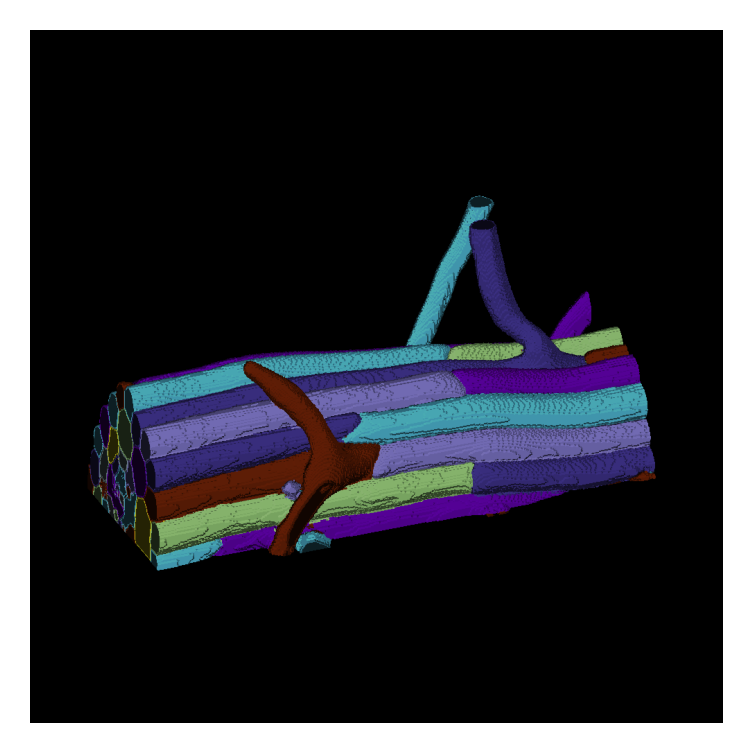

In [ ]:
plt.figure(figsize=(3,3),frameon=False)
plt.imshow(img)
plt.axis('off')

## Plot the network outputs

In [ ]:
# grab the data we want to plot
mu = flows_om[0][1]
T = flows_om[0][2]
bd = flows_om[0][-1]
mu.shape,T.shape,bd.shape

((3, 162, 207, 443), (162, 207, 443), (162, 207, 443))

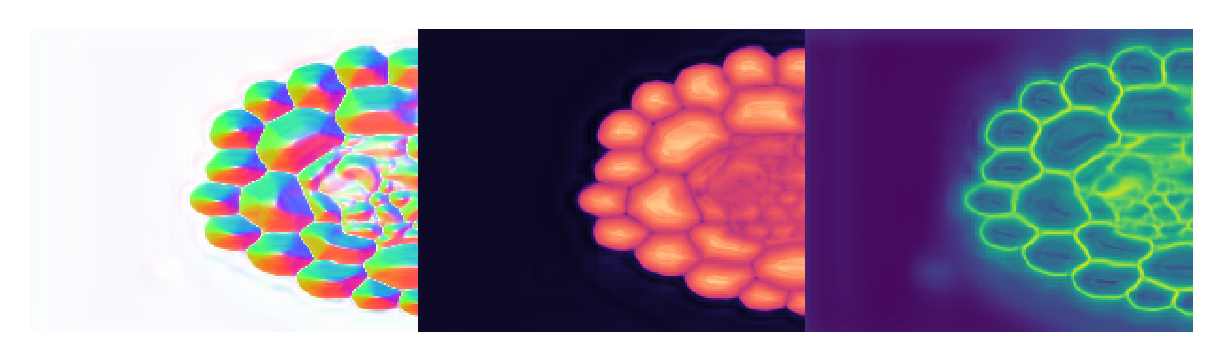

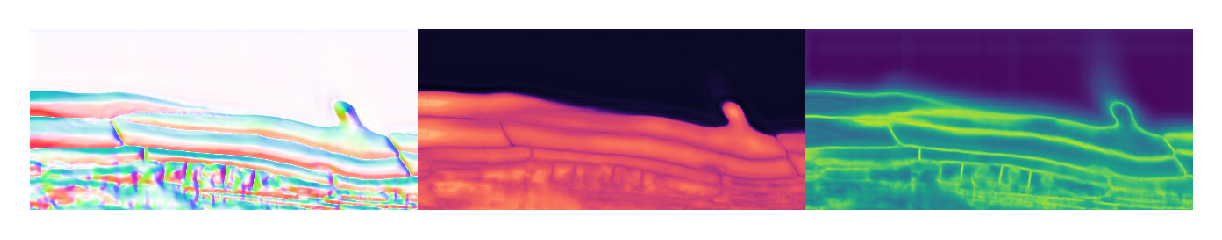

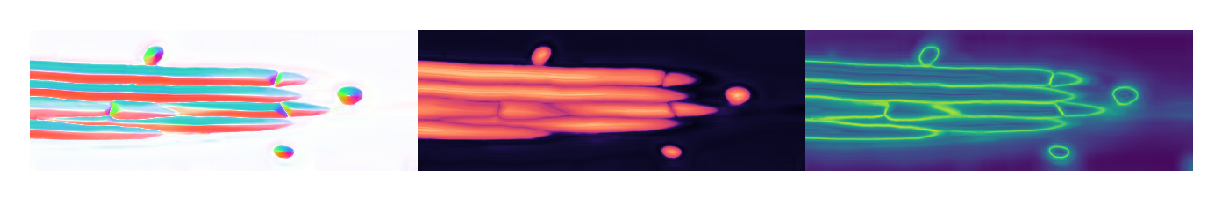

In [ ]:
from cellpose_omni import plot
d = mu.shape[0]

from omnipose.utils import rescale
c = np.array([1]*2+[0]*(d-2))
# c = np.arange(d)
def cyclic_perm(a):
    n = len(a)
    b = [[a[i - j] for i in range(n)] for j in range(n)]
    return b
slices = []
idx = np.arange(d)
cmap = mpl.cm.get_cmap('magma')
cmap2 = mpl.cm.get_cmap('viridis')

for inds in cyclic_perm(c):
    slc = tuple([slice(-1) if i else mu.shape[k+1]//2 for i,k in zip(inds,idx)])
    flow = plot.dx_to_circ(mu[np.where(inds)+slc],transparency=1)/255
    dist = cmap(rescale(T)[slc])
    bnds = cmap2(rescale(bd)[slc])

    fig = plt.figure(figsize=[5]*2,frameon=False)
    plt.imshow(np.hstack((flow,dist,bnds)),interpolation='none')
    plt.axis('off')
    plt.show()

### Notes on the above
Slices do not always look crisp because we are cutting though boundaries. At these locations, the flow and distance fields darken and the boundary field brightens. This can result in flat and muddled regions that are hard to interpret. Again, interactive 3D visualization tools are needed to properly evaluate the results of the segmentation. In this case, we have cut through the middle of enough cells to confirm that the output looks reasonable. 

This small dataset with problematic annotations was sufficient for demonstrating that Omnipose *can* be used on 3D data, but I again emphasize that any algorithm will only work *well* after training on well-annotated, representative examples. In this case, small cell clusters were neither well-annotated nor well-represented in the training set, and you can see the negative impact of that in this example. 

These 3D models are incredibly VRAM-hungry, so all results in the paper were actually run on an AWS instance. Here I ran them on CPU, which is much slower but necessary to do even with a 24GB Titan RTX. 

